## Natural Language Processing with Python


By Anjal Hussan






### Problem Statement
*Using any classifiers, build the best name gender classifier*

--- 


In this project, we will use Naive Bayes and Maximum Entropy classifiers with various features to provide predictions of gender for a English-language name. The dataset used in this project is a labelled corpus of male and female names from the NLTK package: `nltk.corpus.names`.  

**Project structure**  
  
1) Data preparation: in this step the input data is inspected and cleaned, then a holdout set is separated from the training dataset   
2) Initial feature generation and classifier training: the first feature extraction function is applied on the training data, and an initial Naive Bayes model is trained to generate the baseline for model accuracy  
3) Generation of additional features: additional features are generated manually from the data, Naive Bayes classifiers are re-trained and compared using cross-validation  
4) Application of a more complex model - Maximum Entropy on the best set of features and a test vs. the previous iterations  
5) Final test of the best model on the holdout set
  
**Summary of the findings**  
  
1) The dataset had to be cleaned before processing, as it contained records of identical names assigned to both genders.  
2) The most important features for the correct assignment of names are contained in the ending letters, e.g. names ending in "-na" are very likely to be female.  
3) The Maximum Entropy classifier does not perform better than Naive Bayes on the selected set of features, and thus a simpler model was used in the final test.  
4) The final accuracy achieved on the test set was **87.6%**.

### 1. Load and clean the data, prepare the training and test datasets

In [1]:
import nltk

nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\jshi3\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [5]:
from nltk.corpus import names
import random
from nltk.classify import apply_features
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
names = ([(name, "male") for name in names.words("male.txt")] + 
         [(name, "female") for name in names.words("female.txt")])

In [7]:
a = nltk.FreqDist(names)

In [8]:
[item for item in names if item[0]=="Marietta"]

[('Marietta', 'male'), ('Marietta', 'female')]

In [10]:
print (len(names), 100 * len([item for item in names if item[1] == "male"])/len(names))

7944 37.046827794561935


In [11]:
# Check data for distinct names
only_names = [item[0] for item in names]
len(set(only_names))

7579

There are 7944 records in total, 37% are male names, and 63% are female names.
However, there are only 7579 unique names in the dataset.
Before proceeding, we need to clean the names occurring multiple times, as they do not add information, but may skew the classifier results.
  


In [18]:
fdist = nltk.FreqDist(only_names)
duplicates = [(v,k) for k,v in fdist.items() if v >1]
duplicates

[(2, 'Abbey'),
 (2, 'Abbie'),
 (2, 'Abby'),
 (2, 'Addie'),
 (2, 'Adrian'),
 (2, 'Adrien'),
 (2, 'Ajay'),
 (2, 'Alex'),
 (2, 'Alexis'),
 (2, 'Alfie'),
 (2, 'Ali'),
 (2, 'Alix'),
 (2, 'Allie'),
 (2, 'Allyn'),
 (2, 'Andie'),
 (2, 'Andrea'),
 (2, 'Andy'),
 (2, 'Angel'),
 (2, 'Angie'),
 (2, 'Ariel'),
 (2, 'Ashley'),
 (2, 'Aubrey'),
 (2, 'Augustine'),
 (2, 'Austin'),
 (2, 'Averil'),
 (2, 'Barrie'),
 (2, 'Barry'),
 (2, 'Beau'),
 (2, 'Bennie'),
 (2, 'Benny'),
 (2, 'Bernie'),
 (2, 'Bert'),
 (2, 'Bertie'),
 (2, 'Bill'),
 (2, 'Billie'),
 (2, 'Billy'),
 (2, 'Blair'),
 (2, 'Blake'),
 (2, 'Bo'),
 (2, 'Bobbie'),
 (2, 'Bobby'),
 (2, 'Brandy'),
 (2, 'Brett'),
 (2, 'Britt'),
 (2, 'Brook'),
 (2, 'Brooke'),
 (2, 'Brooks'),
 (2, 'Bryn'),
 (2, 'Cal'),
 (2, 'Cam'),
 (2, 'Cammy'),
 (2, 'Carey'),
 (2, 'Carlie'),
 (2, 'Carlin'),
 (2, 'Carmine'),
 (2, 'Carroll'),
 (2, 'Cary'),
 (2, 'Caryl'),
 (2, 'Casey'),
 (2, 'Cass'),
 (2, 'Cat'),
 (2, 'Cecil'),
 (2, 'Chad'),
 (2, 'Chris'),
 (2, 'Chrissy'),
 (2, 'Christian'),


In [19]:
[item for item in names if item[0] in ["Casey","Sandy"]]

[('Casey', 'male'),
 ('Sandy', 'male'),
 ('Casey', 'female'),
 ('Sandy', 'female')]

We can see that all of the duplicate names appear twice, and appear to have both gender labels assigned to them.
This means that the information contained in these names *cannot be used to correctly classify the gender*.
These records will be excluded before any modeling.

In [20]:
# Remove the duplicates
dup_names = [item[1] for item in duplicates]
input_names = [item for item in names if not item[0] in dup_names]
len(input_names)

7214

We shall shuffle the data and split it into 3 sets:
  
1) Hold-out test set of size 500 used only for the evaluation of the final model   
2) Training data consisting of:  
      2a) Initial dev-test set of size 500 used to evaluate the first iterations of the model  
      2b) Initial training set comprizing the remainder of the data
  
With each iteration of the model, the training set will be reshuffled and split again into dev-test and training data

In [21]:
def split_train_test(x, n_test):
    """Randomly splits a list into two lists with n_test records in one, 
    and the remainder in the other one."""
    
    random.shuffle(x)
    
    return x[:n_test],x[n_test:]



In [22]:
test_set, training_data = split_train_test(input_names, 500) 

In [23]:
print (len(test_set), 100 * len([item for item in test_set if item[1] == "male"])/len(test_set))

500 35.4


We see that the proportion of male names is preserved correctly in the holdout data.  

Now we can get our initial training and dev-test datasets from the training data:

In [24]:
dev_test, train_set = split_train_test(training_data, 500) 

### 2. Train and evaluate the initial Naive Bayes classifier

#### Prepare the initial features  
  
Initially, the following features will be used to build an initial Naive Bayes classifier and inspect its errors.
  
1) First letter of the name  
2) Last letter of the name  
3) Length of the name

In [25]:
def gender_features_0(name): 
    features = {}
    features["firstletter"] = name[0].lower() 
    features["lastletter"] = name[-1].lower()
    features["length"] = len([c for c in name])
    
    return features

In [26]:
# Example
gender_features_0("John"), gender_features_0("Amanda")

({'firstletter': 'j', 'lastletter': 'n', 'length': 4},
 {'firstletter': 'a', 'lastletter': 'a', 'length': 6})

#### Train and evaluate the initial classifier
  
In this section we setup the set of functions to train and evaluate Naive Bayes classifiers using different features as inputs and cross-validated accuracy as an output metric. In this way, we can quickly swap the feature generation functions and re-evaluate the classifier performance to find optimal features.

In [28]:
def evaluate_model(dev_test, featurizer, classifier):
    """
    Returns the accuracy, a contingency table, and the most informative features
    of an NLTK classifier.
    Based on the code from: Natural Language Processing with Python
    by Steven Bird, Ewan Klein, and Edward Loper. 2009, O'Reilly Media
    """
    # Generate test features
    dev_test_ft = apply_features(featurizer, dev_test)

    # Score the model on the test features
    model_out = [classifier.classify(item[0]) for item in dev_test_ft]

    # Evaluate the accuracy
    accr = nltk.classify.accuracy(classifier, dev_test_ft)
    

    # Confusion matrix
    true_label = [item[1] for item in dev_test_ft]
    
    
    # Errors: Compare the true label with the classifier output
    errors = []
    for item in zip(dev_test,model_out):
        if item[0][1] != item[1]:
            errors.append( (item[0][1], item[1], item[0][0]))
    
    return dict(model_out = model_out,true_label=true_label,accr=accr,errors=errors)
        
def print_eval_results(classifier, eval_output,err_cnt):
    "Prints model evaluation output"
    
    
    print ("Accuracy on the test set: {}% \n".format(eval_output["accr"]*100))
    # Main features 
    classifier.show_most_informative_features(10)
    
    print ("\n Confusion Matrix: \n")
    print (nltk.ConfusionMatrix(eval_output["true_label"],eval_output["model_out"]))
    print ("\n Errors: \n"), 
    for (tag, guess, name) in eval_output["errors"][:err_cnt]: 
        print ('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

def iterate_nb_validation(data, test_size, featurizer,n_iter):
    
    accuracy_out = []
    
    for item in range(0,n_iter):
    
        # Split dataset
        dev_test, train_set = split_train_test(data, test_size) 

        # Generate training features
        train_ft = apply_features(featurizer, train_set)
    
        # Apply Naive Bayes classifier
        classifier = nltk.NaiveBayesClassifier.train(train_ft)
        eval_result = evaluate_model(dev_test=dev_test, featurizer=featurizer,classifier=classifier)
        
        accuracy_out.append(eval_result["accr"])
        print (".", sep=''),
    
    return accuracy_out

In [29]:
# Split dataset
dev_test, train_set = split_train_test(training_data, 500) 

# Generate training features
train_ft = apply_features(gender_features_0, train_set)

# Apply Naive Bayes classifier
classifier_0 = nltk.NaiveBayesClassifier.train(train_ft)

# Evaluate the features and classifier
eval_0 = evaluate_model(dev_test=dev_test, featurizer=gender_features_0,classifier=classifier_0)
print_eval_results(classifier_0,eval_0,10)

Accuracy on the test set: 81.39999999999999% 

Most Informative Features
              lastletter = 'a'            female : male   =     48.7 : 1.0
              lastletter = 'p'              male : female =     19.6 : 1.0
              lastletter = 'v'              male : female =     18.4 : 1.0
              lastletter = 'f'              male : female =     13.2 : 1.0
              lastletter = 'm'              male : female =     12.2 : 1.0
              lastletter = 'o'              male : female =     11.9 : 1.0
              lastletter = 'd'              male : female =     11.7 : 1.0
              lastletter = 'r'              male : female =      8.7 : 1.0
             firstletter = 'w'              male : female =      5.5 : 1.0
              lastletter = 'g'              male : female =      5.3 : 1.0

 Confusion Matrix: 

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<287> 42 |
  m

We see that in this single validation fold the initial classifier **correctly assigns over 75% of labels**, which is significantly better than using the default split in the data (e.g. simply assigning all data to the class "female" would yield 63% accuracy).
  
Based on the Bayesian likelihood ratios, last letter seems to be the most decisive factor for the "male" or "female" label.

Using a simple cross-validation approach by iteratively randomly splitting the training data into training and dev_test sets we can see how stable these results are in terms of the prediction accuracy: 

In [30]:
nb_gf0 = iterate_nb_validation(data=training_data, test_size=500, 
                               featurizer=gender_features_0,n_iter=30)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


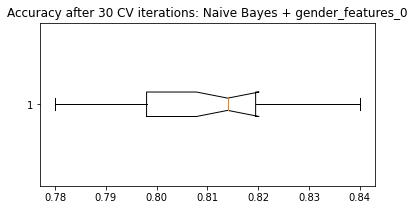

In [31]:
plt.figure(figsize=(6,3))
plt.boxplot(nb_gf0,1,"D",0)
plt.title("Accuracy after 30 CV iterations: Naive Bayes + gender_features_0")
plt.show()

On average, the initial classifier will correctly classify **about 80%** of names, and also that it's performance is  variable between 77% and 83% in 30 training iterations.

### 3. Engineering additional features
  
We can now engineer additional features and compare the accuracy with the above baseline model.  
We will try:  
  
* adding a two-letter prefix and suffix as features (as we saw that the last letter of the word seems to carry more information)  

In addition, as there variations in the way the names are spelled vs. pronounced, adding some form of phonetical features should be added as well. We will try: 
   
* counting the occurrences of similar-sounding consonants (based on the [Soundex](https://en.wikipedia.org/wiki/Soundex?oldformat=true#American_Soundex) groups) 
  

#### Adding Prefix and Suffix features

In [32]:
def gender_features_1(name): 
    features = {}
    features["firstletter"] = name[0].lower() 
    features["lastletter"] = name[-1].lower()
    features["suffix"] = name[-2:].lower()
    features["prefix"] = name[:2].lower()
    features["length"] = len([c for c in name])
    
    return features

In [33]:
# Example
gender_features_1("John"), gender_features_1("Amanda")

({'firstletter': 'j',
  'lastletter': 'n',
  'suffix': 'hn',
  'prefix': 'jo',
  'length': 4},
 {'firstletter': 'a',
  'lastletter': 'a',
  'suffix': 'da',
  'prefix': 'am',
  'length': 6})

In [34]:
# Evaluate the features and classifier
nb_gf1 = iterate_nb_validation(data=training_data, test_size=500, featurizer=gender_features_1,n_iter=30)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


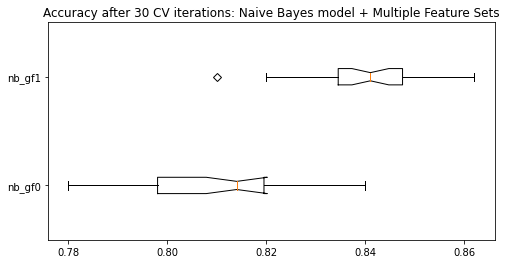

In [35]:
data = [nb_gf0, nb_gf1]
labels=["nb_gf0", "nb_gf1"]
plt.figure(figsize=(8,4))
plt.boxplot(data,1,"D",0,labels=labels)
plt.title("Accuracy after 30 CV iterations: Naive Bayes model + Multiple Feature Sets")
plt.show()

We can see that on average, the approach with added prefixes and suffixes perfoms better than the original approach, and classifies **about 84%** of names correctly.
  
We can inspect a random training and validation fold:

In [36]:
# Split dataset
dev_test, train_set = split_train_test(training_data, 500) 

# Generate training features
train_ft = apply_features(gender_features_1, train_set)

In [37]:
# Apply Naive Bayes classifier
classifier_1 = nltk.NaiveBayesClassifier.train(train_ft)
# Evaluate the features and classifier
eval_1 = evaluate_model(dev_test=dev_test, featurizer=gender_features_1,classifier=classifier_1)
print_eval_results(classifier_1,eval_1,10)

Accuracy on the test set: 83.8% 

Most Informative Features
                  suffix = 'na'           female : male   =    145.1 : 1.0
              lastletter = 'k'              male : female =     71.5 : 1.0
                  suffix = 'la'           female : male   =     65.7 : 1.0
              lastletter = 'a'            female : male   =     58.5 : 1.0
                  suffix = 'ia'           female : male   =     48.2 : 1.0
                  suffix = 'ta'           female : male   =     40.5 : 1.0
                  suffix = 'us'             male : female =     38.4 : 1.0
                  suffix = 'ch'             male : female =     27.6 : 1.0
                  suffix = 'rt'             male : female =     27.1 : 1.0
                  suffix = 'do'             male : female =     25.3 : 1.0

 Confusion Matrix: 

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<281> 32 |
  male |  49<138

Findings: 
  
1) The classifier seems to perform better for male names than the original one.  
2) The suffixes "na", "la", "ia" are very strong predictors of a female name, as well as "a" as the last letter (so probably largely this is already captured by the last letter feature)  
3) The suffixes "ld" and "rt" are important for male names

#### Adding Soundex consonant counts

We add the counts of similar-sounding consonants based on Soundex

In [38]:
def gender_features_2(name): 
    features = {}
    features["firstletter"] = name[0].lower() 
    features["lastletter"] = name[-1].lower()
    features["length"] = len([c for c in name])
    features["sdx_1"] = len([c for c in name if c in ["b", "f", "p", "v"]])
    features["sdx_2"] = len([c for c in name if c in ["c", "g", "j", "k", "q", "s", "x", "z"]])
    features["sdx_3"] = len([c for c in name if c in ["d", "t"]])
    features["sdx_4"] = len([c for c in name if c in ["l"]])
    features["sdx_5"] = len([c for c in name if c in ["m", "n"]])
    features["sdx_6"] = len([c for c in name if c in ["r"]])
    features["sdx_6"] = len([c for c in name if c in ["r"]])
    
    return features

In [39]:
# Example
gender_features_2("Ruddie")

{'firstletter': 'r',
 'lastletter': 'e',
 'length': 6,
 'sdx_1': 0,
 'sdx_2': 0,
 'sdx_3': 2,
 'sdx_4': 0,
 'sdx_5': 0,
 'sdx_6': 0}

In [40]:
# Evaluate the features and classifier
nb_gf2 = iterate_nb_validation(data=training_data, test_size=500, featurizer=gender_features_2,n_iter=30)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


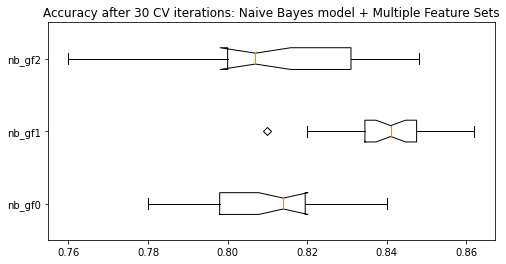

In [41]:
data = [nb_gf0, nb_gf1, nb_gf2]
labels=["nb_gf0", "nb_gf1","nb_gf2"]
plt.figure(figsize=(8,4))
plt.boxplot(data,1,"D",0,labels=labels)
plt.title("Accuracy after 30 CV iterations: Naive Bayes model + Multiple Feature Sets")
plt.show()

We see that the use of similar-sounding consonants does not improve performance above the original version.

We can try expanding the prefix-suffix approach further from the end of the word to see if additional combinations provide a better prediction, or if we will already see worse performance due to overfitting.

In [42]:
def gender_features_3(name): 
    features = {}
    features["firstletter"] = name[0].lower() 
    features["lastletter"] = name[-1].lower()
    features["suffix_2"] = name[-2:].lower()
    features["suffix_3"] = name[-3:].lower()
    features["prefix_2"] = name[:2].lower()
    features["prefix_3"] = name[:3].lower()
    features["length"] = len([c for c in name])
    
    return features

In [43]:
# Evaluate the features and classifier
nb_gf3 = iterate_nb_validation(data=training_data, test_size=500, featurizer=gender_features_3,n_iter=30)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


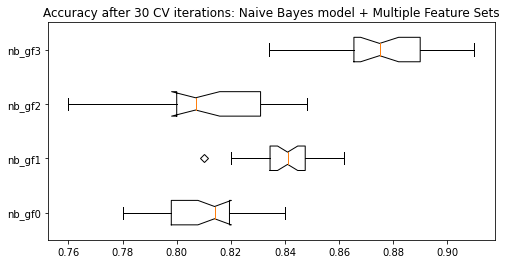

In [44]:
data = [nb_gf0, nb_gf1, nb_gf2, nb_gf3]
labels=["nb_gf0", "nb_gf1","nb_gf2","nb_gf3"]
plt.figure(figsize=(8,4))
plt.boxplot(data,1,"D",0,labels=labels)
plt.title("Accuracy after 30 CV iterations: Naive Bayes model + Multiple Feature Sets")
plt.show()

We can see a significant improvement over the previous versions to around **88%** accuracy, and a smaller variance in the accuracy.    
Finally, we can try a different classifier algorithm that accounts for possible interactions between the features: a Maximum Entropy Classifier.

---
### 4. Using another classifier: Maximum Entropy

We apply a different classifier with the best feature set from the approach above. As it takes significantly longer to train ME classifiers, we shall run just 10 cross-validation iterations.

In [46]:
from nltk.classify import MaxentClassifier

def iterate_me_validation(data, test_size, featurizer,n_iter):
    
    accuracy_out = []
    
    for item in range(0,n_iter):
    
        # Split dataset
        dev_test, train_set = split_train_test(data, test_size) 

        # Generate training features
        train_ft = apply_features(featurizer, train_set)
    
        # Apply Naive Bayes classifier
        algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[1]
        classifier = nltk.MaxentClassifier.train(train_ft, algorithm,max_iter=20)
        eval_result = evaluate_model(dev_test=dev_test, featurizer=featurizer,classifier=classifier)
        
        accuracy_out.append(eval_result["accr"])
        print (".", sep=''),
    
    return accuracy_out

In [47]:
# Evaluate the features and classifier
me_gf3 = iterate_me_validation(data=training_data, test_size=500, featurizer=gender_features_3,n_iter=10)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.357
             2          -0.36762        0.849
             3          -0.28836        0.892
             4          -0.24887        0.905
             5          -0.22451        0.913
             6          -0.20746        0.920
             7          -0.19455        0.925
             8          -0.18425        0.931
             9          -0.17574        0.934
            10          -0.16852        0.938
            11          -0.16228        0.941
            12          -0.15678        0.943
            13          -0.15190        0.947
            14          -0.14751        0.950
            15          -0.14353        0.953
            16          -0.13991        0.954
            17          -0.13658        0.957
            18          -0.13351        0.958
            19          -0.13067        0.959
  

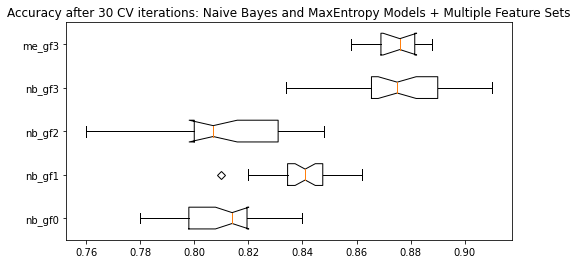

In [48]:
data = [nb_gf0, nb_gf1, nb_gf2, nb_gf3, me_gf3]
labels=["nb_gf0", "nb_gf1","nb_gf2","nb_gf3","me_gf3"]
plt.figure(figsize=(8,4))
plt.boxplot(data,1,"D",0,labels=labels)
plt.title("Accuracy after 30 CV iterations: Naive Bayes and MaxEntropy Models + Multiple Feature Sets")
plt.show()

We can see that this classifier performs on par with Naive Bayes on the same set of features, achieving **above 86%** accuracy.
We can now inspect a random training fold to understand the feature importance for this classifier:

In [49]:
# Split dataset
dev_test, train_set = split_train_test(training_data, 500) 

# Generate training features
train_ft = apply_features(gender_features_3, train_set)

In [50]:
# Apply Naive Bayes classifier
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[1]
classifier_me = nltk.MaxentClassifier.train(train_ft, algorithm,max_iter=20)

# Evaluate the features and classifier
eval_me = evaluate_model(dev_test=dev_test, featurizer=gender_features_3,classifier=classifier_me)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.355
             2          -0.37009        0.848
             3          -0.29094        0.893
             4          -0.25124        0.907
             5          -0.22672        0.915
             6          -0.20955        0.921
             7          -0.19655        0.927
             8          -0.18619        0.932
             9          -0.17762        0.936
            10          -0.17034        0.942
            11          -0.16404        0.945
            12          -0.15851        0.947
            13          -0.15359        0.949
            14          -0.14916        0.951
            15          -0.14516        0.953
            16          -0.14150        0.954
            17          -0.13815        0.955
            18          -0.13506        0.957
            19          -0.13220        0.958
  

In [51]:
print_eval_results(classifier=classifier_me,eval_output=eval_me,err_cnt=10)

Accuracy on the test set: 86.4% 

   7.076 suffix_3=='hna' and label is 'male'
  -5.793 lastletter=='k' and label is 'female'
   5.398 prefix_3=='eti' and label is 'male'
  -4.814 prefix_3=='ros' and label is 'male'
   4.667 prefix_3=='kle' and label is 'male'
  -4.484 lastletter=='a' and label is 'male'
  -4.476 suffix_2=='na' and label is 'male'
   4.127 suffix_3=='zra' and label is 'male'
   4.127 prefix_3=='ezr' and label is 'male'
  -4.126 lastletter=='p' and label is 'female'

 Confusion Matrix: 

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<285> 23 |
  male |  45<147>|
-------+---------+
(row = reference; col = test)


 Errors: 

correct=female   guess=male     name=Benoite                       
correct=male     guess=female   name=Davide                        
correct=male     guess=female   name=Antone                        
correct=female   guess=male     name=Solange          

Findings:  
1) The feature importance of the Maximum Entropy model is significantly harder to interpret, as multiple feature interactions are involved in defining the probability of a label  
2) The errors returned by this classifier show some difficult cases, where it is hard to say from the sound of the name to which gender it belongs such as "Rafa" or "Hollis".  
3) However, some "simple" names such as "Emily" were also misclassified.

---

### 5. Performance on the holdout set

As both the Naive Bayes and the Maximum Entropy classifier performed well on the training data, we choose the more parsimonious model - Naive Bayes - to continue and test the performance on the holdout test set.
  
This time though, we will train the Naive Bayes classifier on the full training dataset.

In [56]:
# Train NB classifier on all training data

classifier_final = nltk.NaiveBayesClassifier.train(train_ft)

In [57]:
# Evaluate the features and the trained classifier
eval_test = evaluate_model(dev_test=test_set, featurizer=gender_features_3,classifier=classifier_final)
print_eval_results(classifier_final,eval_test,10)

Accuracy on the test set: 89.2% 

Most Informative Features
                suffix_2 = 'na'           female : male   =    143.2 : 1.0
              lastletter = 'k'              male : female =     72.9 : 1.0
                suffix_2 = 'la'           female : male   =     66.2 : 1.0
                suffix_2 = 'ra'           female : male   =     56.4 : 1.0
                suffix_2 = 'ia'           female : male   =     49.0 : 1.0
              lastletter = 'a'            female : male   =     48.2 : 1.0
                suffix_2 = 'ta'           female : male   =     39.3 : 1.0
                suffix_2 = 'us'             male : female =     39.2 : 1.0
                suffix_2 = 'rt'             male : female =     29.3 : 1.0
              lastletter = 'f'              male : female =     25.9 : 1.0

 Confusion Matrix: 

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<291> 32 |
  male |  22<155

The final Naive Bayes classifier is performing comparably well on the holdout set compared to the previous cross-validation iterations achieving **87.6% accuracy**.  
We can see that among the remaining 62 misclassified male and female names, a few are rare or unusually sounding for their gender: such as female names "Chrysler", "Ealasaid", and "Doloritas", and a male name "Klee".

### Reference

[Chapter 6: Learning to Classify Text](http://www.nltk.org/book/ch06.html) from  
Natural Language Processing with Python, by Steven Bird, Ewan Klein and Edward Loper, Copyright © 2014 the authors. 